In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import fastai
from random import randint
from fastai.text import SortishSampler
from fastai.basic_data import DataBunch

In [2]:
ROOT = "../../data/protein/structure/secondary_structure/"
DATA_PATH = ROOT+"cullpdb"
EMBEDDING_PATH = "../../data/protein/classification/data_sources/protVec_100d_3grams.csv"
MODEL_PATH = "../../weights/protein/structure/secondary_structure/1_kmers/"
SEQUENCE_LENGTH=729
NUM_CLASSES = 9

In [3]:
features = np.array([16, 32, 64, 128, 256])*2
num_workers = 8 # On cloud 8
batch_size = 256

In [4]:
features

array([ 32,  64, 128, 256, 512])

In [5]:
class EnzymeDataSet(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data, transform=None):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        return np.int64(row[0]), np.int64(row[1])

In [6]:
embeddings = np.eye(22,22)
#embeddings = np.loadtxt(open(EMBEDDING_PATH, "rb"), delimiter="\t", skiprows=1, usecols=[i for i in range(1,101)])

In [7]:
train = np.load(DATA_PATH+"/train/data.npy")
val = np.load(DATA_PATH+"/val/data.npy")
test = np.concatenate([np.load(DATA_PATH+"/test/data.npy"),np.load(DATA_PATH+"/test/data.npy")],axis=0)
#test = np.load(DATA_PATH+"/test/data.npy")

In [8]:
len(train)
np.unique(np.concatenate(train[:,1]).ravel(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([2751851,   12150,  225660,  253710,   45607,  401508,     222,   96906,  132386]))

In [9]:
train_sampler = SortishSampler(train, key=lambda x: len(train[x][0]), bs=batch_size//2)
val_sampler = SortishSampler(val, key=lambda x: len(val[x][0]), bs=batch_size//2)
test_sampler = SortishSampler(test, key=lambda x: len(test[x][0]), bs=batch_size//2)

In [10]:
def pad_tensor(seq, label, length):
    seq_len = len(seq)
    to_pad = length - seq_len
    end_padding = randint(0, to_pad)
    begin_padding = to_pad - end_padding
    seq = np.pad(seq, mode="constant", pad_width=(begin_padding,end_padding))
    label = np.pad(label, mode="constant", pad_width=(begin_padding,end_padding))
    return seq,label

In [11]:
def pad_collate(samples, random=True):
    "Function that collect samples and adds padding."
    max_len = max(64 ,max(map(lambda x: len(x[0]), samples)))
    batch = list(map(lambda x: pad_tensor(x[0], x[1], max_len), samples))
    # stack all
    x = torch.stack([torch.from_numpy(b[0]) for b in batch], 0)
    y = torch.stack([torch.from_numpy(b[1]) for b in batch], 0)
    return x, y

In [12]:
train_ds = EnzymeDataSet(train)
val_ds = EnzymeDataSet(val)
test_ds = EnzymeDataSet(test)

In [13]:
dls = [DataLoader(*o, num_workers=num_workers) for o in
       zip((train_ds, val_ds, test_ds), (batch_size,batch_size*2,batch_size*2), 
           (False,False,False), (train_sampler, val_sampler, test_sampler))]
data = DataBunch(*dls, collate_fn=pad_collate)

In [14]:
class UnetDown(nn.Module):

    def __init__(self, num_inputs, num_outputs, kernel_size, strides, dilation_rate=1, dropout=0.2, act=F.selu, pool=True):
        super(UnetDown, self).__init__()
        self.act = act
        self.conv1 = nn.Conv1d(num_inputs, num_inputs, kernel_size, stride=1, dilation = 1)
        self.conv2 = nn.Conv1d(num_inputs, num_inputs, kernel_size, stride=1, dilation = dilation_rate)
        self.pool = nn.Conv1d(num_inputs, num_outputs, kernel_size, stride=strides, dilation = 1)
        self.bn1 = nn.BatchNorm1d(num_inputs)
        self.bn2 = nn.BatchNorm1d(num_inputs)
        self.to_pool = pool
        before = (kernel_size -1) // 2
        after = (kernel_size -1) - before
        self.padding = nn.ConstantPad1d((before,after), 0)
        stride_padding = (strides - 1) // 2
        self.padding_stride = nn.ConstantPad1d((before-stride_padding, after -((strides - 1)-stride_padding)), 0)
        
    def forward(self, x):
        out = self.conv1(self.padding(x))
        before_pooling = self.act(self.bn1(out))
#         out = self.conv2(self.padding(out))
#         before_pooling = self.act(self.bn2(out))
        if self.to_pool:
            out = self.pool(self.padding_stride(before_pooling))
            return out, before_pooling
        else:
            return before_pooling

In [107]:
class UnetUp(nn.Module):
    def __init__(self,  num_inputs, num_outputs, kernel_size, strides, dilation_rate=1, dropout=0.2, act=F.relu):
        super(UnetUp, self).__init__()
        self.act = act
        self.up = nn.ConvTranspose1d(num_inputs, num_outputs, kernel_size, stride=strides, dilation = 1, padding=kernel_size-1)
        self.conv1 = nn.Conv1d(num_outputs*2, num_outputs, kernel_size, stride=1, dilation = dilation_rate)
        self.conv2 = nn.Conv1d(num_inputs, num_outputs, kernel_size, stride=1, dilation = 1)
        
        self.bn1 = nn.BatchNorm1d(num_outputs)
        self.bn2 = nn.BatchNorm1d(num_outputs)
        self.before = (kernel_size -1) // 2
        self.after = (kernel_size -1) - self.before
        self.padding = nn.ConstantPad1d((self.before,self.after), 0)
        self.strides = strides
        
    def forward(self, x, across):  
#         stride_padding = self.strides//2
#         extra = 1- across.shape[2]%2
#         self.padding_stride = nn.ConstantPad1d((self.before-(stride_padding+extra), 
#                                                   self.after -((self.strides+1)-stride_padding)), 0)
        out = self.act(self.bn2(self.conv2((self.padding(x)))))
#         print(x.shape, out.shape, across.shape)
#         if out.shape[2] != across.shape[2]:
#             out = nn.ReflectionPad1d((0, 1))(out)
        
        out = torch.cat([out, across], 1)

        out = self.conv1(self.padding(out))
        out = self.act(self.bn1(out))
#         out = self.conv2(self.padding(out))
#         out = self.act(self.bn2(out))
        return out

In [124]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
        #Encoder
        self.embedding = nn.Embedding(embeddings.shape[0], embeddings.shape[1])
        self.embedding.from_pretrained(torch.from_numpy(embeddings)) 
        self.emb_cov = nn.Conv1d(embeddings.shape[1], features[0], 1)
        self.unet_down1 = UnetDown(features[0], features[1], 5, 1)   
        self.unet_down2 = UnetDown(features[1], features[2], 5, 1)  
        self.unet_down3 = UnetDown(features[2], features[3], 7, 1)
        self.unet_down4 = UnetDown(features[3], features[4], 9, 1)        
        
        self.center = UnetDown(features[3], features[3], 9, 1, pool=False)        
        #Decoder
        self.unet_block1 = UnetUp(features[4], features[3], 9, 1)   
        self.unet_block2 = UnetUp(features[3], features[2], 7, 1)  
        self.unet_block3 = UnetUp(features[2], features[1], 5, 1)
        self.unet_block4 = UnetUp(features[1], features[0], 5, 1)
        self.classification = nn.Conv1d(features[0], NUM_CLASSES, 1)

    def forward(self, x):
        embedded_seq = self.embedding(x)
        embedded_seq.transpose_(1, 2)
        embedded_seq = self.emb_cov(embedded_seq)
        d1, before_pooling1 = self.unet_down1(embedded_seq)
        d1 = nn.Dropout(p=0.3)(d1)
        d2, before_pooling2 = self.unet_down2(d1)
        d2 = nn.Dropout(p=0.4)(d2)
        d3, before_pooling3 = self.unet_down3(d2)
        d3 = nn.Dropout(p=0.5)(d3)
        #d4, before_pooling4 = self.unet_down4(d3)
        
        c = self.center(d3)
        
        #u1 = self.unet_block1(c, before_pooling4)
        c = nn.Dropout(p=0.5)(c)
        u2 = self.unet_block2(c, before_pooling3)
        u2 = nn.Dropout(p=0.4)(u2)
        u3 = self.unet_block3(u2, before_pooling2) 
        u3 = nn.Dropout(p=0.3)(u3)
        u4 = self.unet_block4(u3, before_pooling1) 
        u4 = nn.Dropout(p=0.2)(u4)
        output = self.classification(u4)
        return output

In [125]:
def accuracy(input, targs):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    mask = (targs > 0)
    targs = targs.masked_select(mask)
    input = input.argmax(dim=1)
    input = input.masked_select(mask)
    return (input==targs).float().mean()

In [126]:
unet = Unet().cuda()

In [127]:
#criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.1, 1, 1, 1, 1, 1, 1, 1, 1]).cuda())
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.1, 4.4, 1.2, 1.4, 3.1, 1, 8.5, 2.4, 2]).cuda())
optimizer = optim.Adam(unet.parameters(), lr=0.001)

In [128]:
learner = fastai.basic_train.Learner(data, unet, 
        loss_func=criterion, 
        metrics=accuracy, 
        path=None, 
        model_dir='models')

In [129]:
learner.fit(5, lr=0.001)

Total time: 00:40
epoch  train_loss  valid_loss  accuracy
1      1.956740    1.965885    0.349779  (00:08)
2      1.823577    1.840537    0.418104  (00:08)
3      1.722737    1.600625    0.495742  (00:07)
4      1.640784    1.509838    0.482521  (00:07)
5      1.571316    1.452152    0.509797  (00:08)



In [130]:
learner.fit_one_cycle(30)

Total time: 04:00
epoch  train_loss  valid_loss  accuracy
1      1.428238    1.415173    0.517290  (00:08)
2      1.413039    1.389913    0.510252  (00:08)
3      1.391551    1.388196    0.521880  (00:08)
4      1.365236    1.323021    0.524024  (00:08)
5      1.336712    1.288753    0.532218  (00:07)
6      1.311779    1.316239    0.541456  (00:08)
7      1.288687    1.245313    0.531118  (00:07)
8      1.269979    1.278062    0.537757  (00:08)
9      1.255617    1.276133    0.531080  (00:07)
10     1.246099    1.230438    0.544965  (00:08)
11     1.235908    1.353615    0.548986  (00:08)
12     1.226104    1.212207    0.539483  (00:08)
13     1.217496    1.208717    0.544699  (00:08)
14     1.210322    1.206868    0.550807  (00:07)
15     1.204957    1.210585    0.546596  (00:07)
16     1.200524    1.193573    0.550579  (00:07)
17     1.196165    1.205618    0.557598  (00:08)
18     1.191939    1.187074    0.560500  (00:08)
19     1.188269    1.191825    0.560140  (00:07)
20     1.18

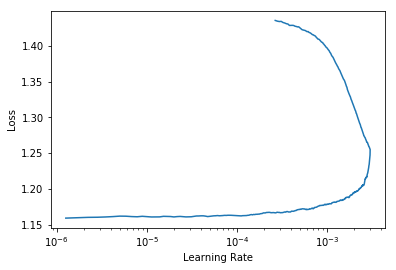

In [131]:
learner.recorder.plot()

In [116]:
preds, truth = learner.get_preds(is_test=True)

In [117]:
accuracy(preds, truth)

tensor(0.5637)

In [118]:
acc = []
min_element = 0
min_score = 1
s = [0, 0, 0, 0, 0, 0, 0, 0, 0]
s_t = [0, 0, 0, 0, 0, 0, 0, 0, 0]
total = [0, 0, 0, 0, 0, 0, 0, 0, 0]
for row in range(len(truth)):

    a = preds.argmax(dim=1)[row]
    correct = 0
    actual = 0
    for i, t in enumerate(truth[row]):
        s[t] = s[t]+1
        total[a[i]] = total[a[i]]+1
        if t != 0: # and t != 1:
            actual += 1
            if a[i] == t:        
                correct += 1
                s_t[t] = s_t[t]+1
    score = correct/actual
    if min_score > score:
        min_score = score
        min_element = row
    acc.append(score)

print(np.mean(acc))

0.5853871591714788


In [119]:
np.array(s_t)/np.array(s)

/home/donatas_repecka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.      , 0.007987, 0.348927, 0.704149, 0.175282, 0.752782,      nan, 0.244321, 0.468413])

In [120]:
import pandas as pd
print("|".join(["{0: <6}".format(x) for x in s_t]))
print("|".join(["{0: <6}".format(x) for x in s]))
print("|".join(["{0: <6}".format(x) for x in total]))

0     |10    |7347  |17208 |807   |30444 |0     |2194  |5902  
267428|1252  |21056 |24438 |4604  |40442 |0     |8980  |12600 
267415|47    |13667 |30250 |4121  |39828 |0     |8813  |16659 


In [121]:
print(min_score)
preds.argmax(dim=1)[min_element], truth[min_element]

0.26262626262626265


(tensor([2, 2, 2, 2, 5, 5, 5, 5, 2, 8, 8, 7, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8,
         7, 2, 4, 4, 4, 3, 3, 3, 3, 8, 8, 7, 3, 3, 2, 4, 8, 8, 7, 2, 3, 3, 3, 3,
         3, 5, 8, 2, 3, 3, 7, 7, 2, 7, 7, 7, 8, 7, 2, 2, 2, 4, 8, 3, 3, 3, 3, 3,
         8, 8, 7, 8, 7, 2, 3, 3, 7, 2, 8, 8, 7, 8, 8, 2, 2, 8, 8, 7, 7, 2, 3, 3,
         3, 3, 3, 3, 3, 7, 7, 2, 8, 7, 3, 3, 2, 3, 5, 7, 2, 5, 3, 3, 8, 8, 8, 8,
         8, 3, 3, 3, 2, 2, 8, 8, 7, 2, 1, 7, 2, 7, 7, 3, 4, 8, 3, 3, 8, 7, 7, 8,
         8, 2, 2, 8, 8, 8, 2, 4, 8, 3, 2, 7, 8, 8, 2, 3, 3, 2, 4, 4, 4, 4, 7, 8,
         2, 3, 3, 3, 3, 7, 2, 4, 4, 4, 8, 8, 7, 7, 7, 7, 2, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

In [123]:
t_s = ""
p_s = ""
element = 4
p = preds.argmax(dim=1)[element]
for i, t in enumerate(truth[element]):
    if t != 0:
        t_s += str(int(t))
        p_s += str(int(p[i]))
print(t_s)
print(p_s)

2333333244455555555555588733333337772721227333337255555555551288233333377722772233444555555555882233333333333388333337733333228872233333338872233333733333284444888444822222882233333337278822223333882233333333333338833333333333333333333332882255555555522722
2333333332222885555333288333333333778727233333333785555555555888233333388888233372555555555555888223333333333358873333333333338887333333333338333333883333788723333333333332883333332877873333333332882333333777333338833382333333388733333322882333333355888822
